# Online Phase: from measurements to high-dimensional state
This notebook used the snapshots from the FOM to extract the measurements needed to estimate the full state of the system and assess if it close the true solution.

The model is trained with iFOM snapshots.

Let us generate the mesh and make a plot of it

In [1]:
from dolfinx.io import gmshio
from mpi4py import MPI
import pyvista as pv
from IPython.display import clear_output as clc

gdim = 2

domain, ct, ft = gmshio.read_from_msh("TWIGL2D.msh", MPI.COMM_WORLD, gdim = gdim)
clc()

Let us load the snapshots

In [3]:
from pyforce.tools.write_read import ImportH5
import numpy as np
from sklearn.model_selection import train_test_split
from pyforce.tools.functions_list import FunctionsList
from dolfinx.fem import FunctionSpace
from pyforce.tools.backends import LoopProgress

D1_parameters = np.linspace(0.5, 2, 25) # parameter space
var_names = ['phi_1', 'phi_2', 'T']

path_ifom = '../../../Data/TWIGL2D/iFOM/'
path_fom  = '../../../Data/TWIGL2D/FOM/'

# Generate functional space
fun_space = {
    field: FunctionSpace(domain, ("Lagrange", 1)) for field in var_names
}

_, test_idx, _, test_params = train_test_split(   np.arange(1, len(D1_parameters)+1), 
                                                  D1_parameters, 
                                                  test_size=0.25, random_state=20)

test_idx = np.sort(test_idx)

test_ifom_snaps = dict()
test_fom_snaps  = dict()


for field in var_names:
    test_fom_snaps[field]  = FunctionsList(function_space=fun_space[field])
    test_ifom_snaps[field] = FunctionsList(function_space=fun_space[field])

    bar = LoopProgress(msg=f"Loading {field} snapshots", final=len(test_idx))

    for idx in test_idx:
        
        # Load iFOM snapshots
        _tmp_snap, ifom_times = ImportH5(fun_space[field], 
                                         path_ifom + f"D1_{idx}/{field}",
                                         field)
        for snap in _tmp_snap._list:
            test_ifom_snaps[field].append(snap)

        # Load FOM snapshots
        _tmp_snap, fom_times = ImportH5(fun_space[field], 
                                        path_fom + f"D1_{idx}/{field}",
                                        field)
        for snap in _tmp_snap._list:
            test_fom_snaps[field].append(snap)

        # Update progress bar
        bar.update(1)

ifom_times = np.asarray(ifom_times)
fom_times  = np.asarray(fom_times)

Loading phi_1 snapshots: 7.000 / 7.00 - 0.012 s/it
Loading phi_2 snapshots: 7.000 / 7.00 - 0.011 s/it
Loading T snapshots: 7.000 / 7.00 - 0.011 s/it


Let us compute the difference between the FOM and the iFOM snapshots

In [ ]:
from pyforce.tools.backends import norms

error_models = dict()

for field in var_names:

    _norm = norms(fun_space[field])
    _err_model = list()

    for mu in range(len(test_idx)):
        for tt in range(len(ifom_times)):
            _ifom_snap = test_ifom_snaps[field](mu * len(ifom_times) + tt)
            _fom_snap  = test_fom_snaps[field]( mu * len(fom_times)  + tt)

            _err = _norm.L2norm(_fom_snap - _ifom_snap) / _norm.L2norm(_fom_snap)
            _err_model.append(_err)

    _err_model = np.asarray(_err_model)

    error_models[field] = _err_model.mean()

## Error Calculation on the whole test set

Let us define the dictionary for the error calculations

In [11]:
online_test_results = {
    'GEIM': dict(),
    'PBDW': dict(),
}

### Generalised Empirical Interpolation Method (GEIM)

The online phase of the GEIM is used to estimate the full state of the system from the measurements.

Let us load the magic functions and sensors, along with the training $\beta$ coefficients.

In [14]:
from pyforce.tools.write_read import ImportH5

path_geim_offline = 'Results/GEIM_offline/'
strategies = ['ID', 'BF', 'BP']

magic_functions = {field: ImportH5(fun_space[field],
                          path_geim_offline+f'GEIM_{field}_mf',
                          f'GEIM_{field}_mf')[0]
                for field in var_names}
magic_sensors = {field: ImportH5(fun_space[field],
                                 path_geim_offline+f'GEIM_{field}_ms',
                          f'GEIM_{field}_ms')[0]
                for field in var_names}

training_betas = {field: np.load(path_geim_offline+f'GEIM_{field}_TrainBeta.npz')['beta']
                  for field in var_names}

mean_beta = {field: np.mean(training_betas[field], axis=0)
                for field in var_names}
std_beta = {field: np.std(training_betas[field], axis=0)
                for field in var_names}

Let us compute the synthetic test error for the online phase.

In [12]:
from pyforce.online.tr_geim import TRGEIM

Mmax = 20
noise_values = [0.025, 0.025, 1]

trgeim_online = dict()

for field_i, field in enumerate(var_names):
    trgeim_online[field] = TRGEIM(magic_functions[field], magic_sensors[field], 
                                  mean_beta[field], std_beta[field], field)
    
    res = trgeim_online[field].synt_test_error( test_fom_snaps[field],
                                                noise_value = noise_values[field_i], reg_param = noise_values[field_i]**2,
                                                M = Mmax, verbose=True)
    
    online_test_results['GEIM'][field] = {
        'abs_err':    res[0],
        'rel_err':    res[1],
        'compt_time': res[2]
    }

Computing TR-GEIM test error (synthetic) - phi_1: 707.000 / 707.00 - 0.004 s/it
Computing TR-GEIM test error (synthetic) - phi_2: 707.000 / 707.00 - 0.004 s/it
Computing TR-GEIM test error (synthetic) - T: 707.000 / 707.00 - 0.004 s/it


### Parameterised-Background Data-Weak (PBDW) formulation
The online phase of the PBDW is used to estimate the full state of the system from the measurements.

Let us load the basis functions and sensors.

In [20]:
path_pod_offline = 'Results/POD_offline/'
path_sgreedy_offline = 'Results/SGREEDY_offline/'

# Load the POD modes
pod_modes = dict()

for field_i, field in enumerate(var_names):
    pod_modes[field] = ImportH5(fun_space[field],
                                path_pod_offline+f'POD_modes_{field}',
                                f'POD_modes_{field}')[0]
    
# Load the SGREEDY sensors
sgreedy_sensors = dict()

for field_i, field in enumerate(var_names):
    sgreedy_sensors[field] = ImportH5(fun_space[field],
                                      path_sgreedy_offline+f'SGREEDY_{field}_sens',
                                      f'SGREEDY_{field}_sens')[0]

Let us compute the synthetic test error for the online phase.

In [24]:
from pyforce.online.pbdw import PBDW

pbdw_online = dict()

Nmax = 5

for field_i, field in enumerate(var_names):
    pbdw_online[field] = PBDW(pod_modes[field], sgreedy_sensors[field], field, is_H1=True)

    res = pbdw_online[field].synt_test_error(   test_fom_snaps[field],
                                                N=Nmax, M=Mmax, 
                                                noise_value = noise_values[field_i], verbose=True)
    

    online_test_results['PBDW'][field] = {
        'abs_err':    res[0],
        'rel_err':    res[1],
        'compt_time': res[2]
    }

Computing PBDW test error (synthetic) with N = 5 - phi_1: 707.000 / 707.00 - 0.005 s/it
Computing PBDW test error (synthetic) with N = 5 - phi_2: 707.000 / 707.00 - 0.005 s/it
Computing PBDW test error (synthetic) with N = 5 - T: 707.000 / 707.00 - 0.005 s/it


### Comparison of the methods
Let us compare the errors of the two methods.

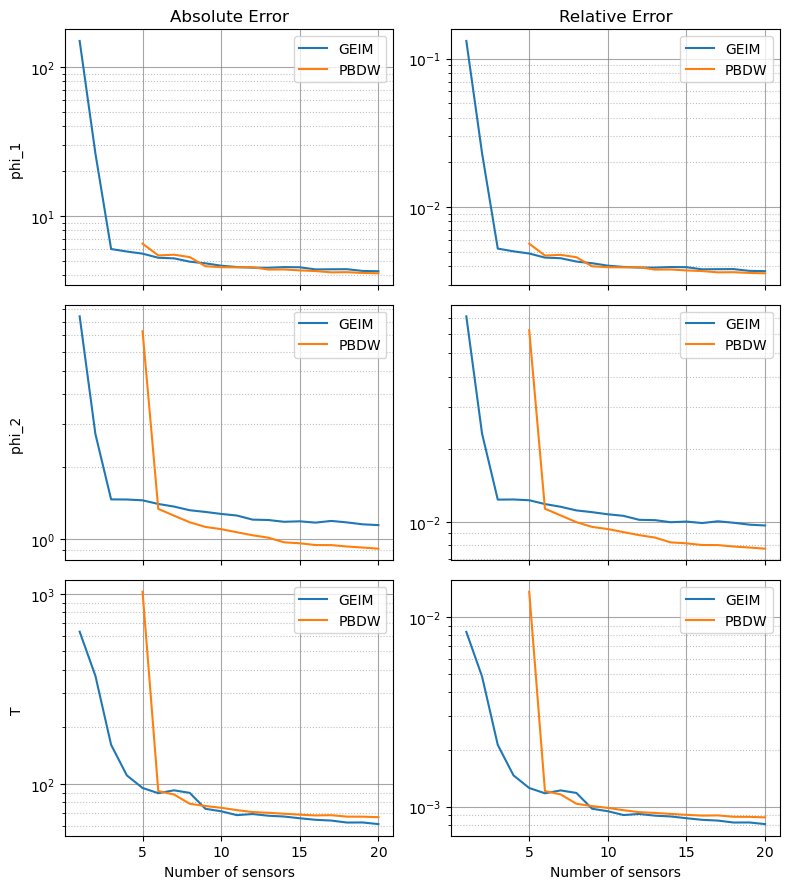

In [33]:
from matplotlib import lines, pyplot as plt

Nplots = {
    'GEIM': np.arange(1, Mmax + 1),
    'PBDW': np.arange(Nmax, Mmax + 1)
}

fig, axs = plt.subplots(len(var_names), 2, figsize=(4 * 2, 3 * len(var_names)), sharex=True)

for field_i, field in enumerate(var_names):

    for method in online_test_results.keys():
        axs[field_i, 0].semilogy(Nplots[method], online_test_results[method][field]['abs_err'], label=method)
        axs[field_i, 1].semilogy(Nplots[method], online_test_results[method][field]['rel_err'], label=method)

    axs[field_i, 0].set_ylabel(f"{field} ")

axs[0, 0].set_title(f"Absolute Error")
axs[0, 1].set_title(f"Relative Error")

for ax in axs.flatten():
    ax.grid(which='major', linestyle='-', color='gray', alpha=0.7)
    ax.grid(which='minor', linestyle=':', color='gray', alpha=0.5)
    ax.legend()

[axs[-1, i].set_xlabel("Number of sensors") for i in range(2)]

plt.tight_layout()

Let us compare the errors of the two methods using 20 sensors, compared with the iFOM error.

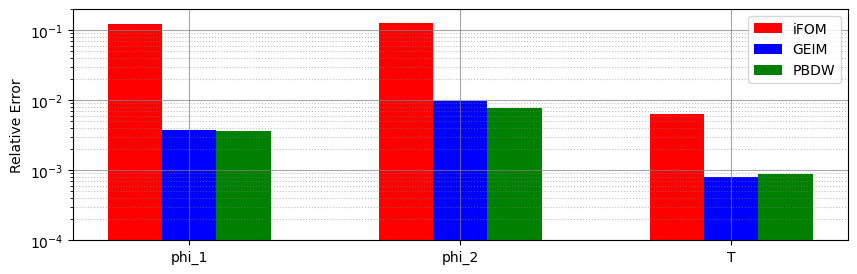

In [64]:
fig = plt.figure(figsize=(10, 3))

# Plot the error models
plt.bar(np.arange(len(var_names)), 
        [error_models[field] for field in var_names], 
        tick_label=var_names, 
        width=0.2,
        color='r')

# GEIM
plt.bar(np.arange(len(var_names)) + 0.2, 
        [online_test_results['GEIM'][field]['rel_err'][-1] for field in var_names], 
        tick_label=var_names, 
        width=0.2,
        color='b')

# PBDW
plt.bar(np.arange(len(var_names)) + 0.4, 
        [online_test_results['PBDW'][field]['rel_err'][-1] for field in var_names], 
        tick_label=var_names, 
        width=0.2,
        color='g')

ax = plt.gca()
ax.set_yscale('log')
ax.legend(['iFOM', 'GEIM', 'PBDW'])
ax.set_xticks(np.arange(len(var_names)) + 0.2, var_names)
ax.set_ylabel("Relative Error")
ax.set_ylim(1e-4, 0.2)

ax.grid(which='major', linestyle='-', color='gray', alpha=0.7)
ax.grid(which='minor', linestyle=':', color='gray', alpha=0.5)

# Comparison of the methods with 20 sensors
Let us reconstruct the full state of the system using the 20 sensors for both methods and compare with FOM and iFOM

In [78]:
M = Mmax

recons = {
    'GEIM': dict(),
    'PBDW': dict(),
}

for field_i, field in enumerate(var_names):

    # GEIM reconstruction
    recons['GEIM'][field] = list()
    for snap in test_fom_snaps[field]._list:
        recons['GEIM'][field].append(trgeim_online[field].reconstruct(  snap, 
                                                                        M=M, 
                                                                        noise_value=noise_values[field_i],
                                                                        reg_param=noise_values[field_i]**2)[0])

    # PBDW reconstruction
    recons['PBDW'][field] = list()
    for snap in test_fom_snaps[field]._list:
        recons['PBDW'][field].append(pbdw_online[field].reconstruct(snap, 
                                                                    N=Nmax, M=M, 
                                                                    noise_value=noise_values[field_i])[0])
        
    # Convert to Matrix
    recons['GEIM'][field] = np.asarray(recons['GEIM'][field]).T
    recons['PBDW'][field] = np.asarray(recons['PBDW'][field]).T

Let us compare the average values of the different fields

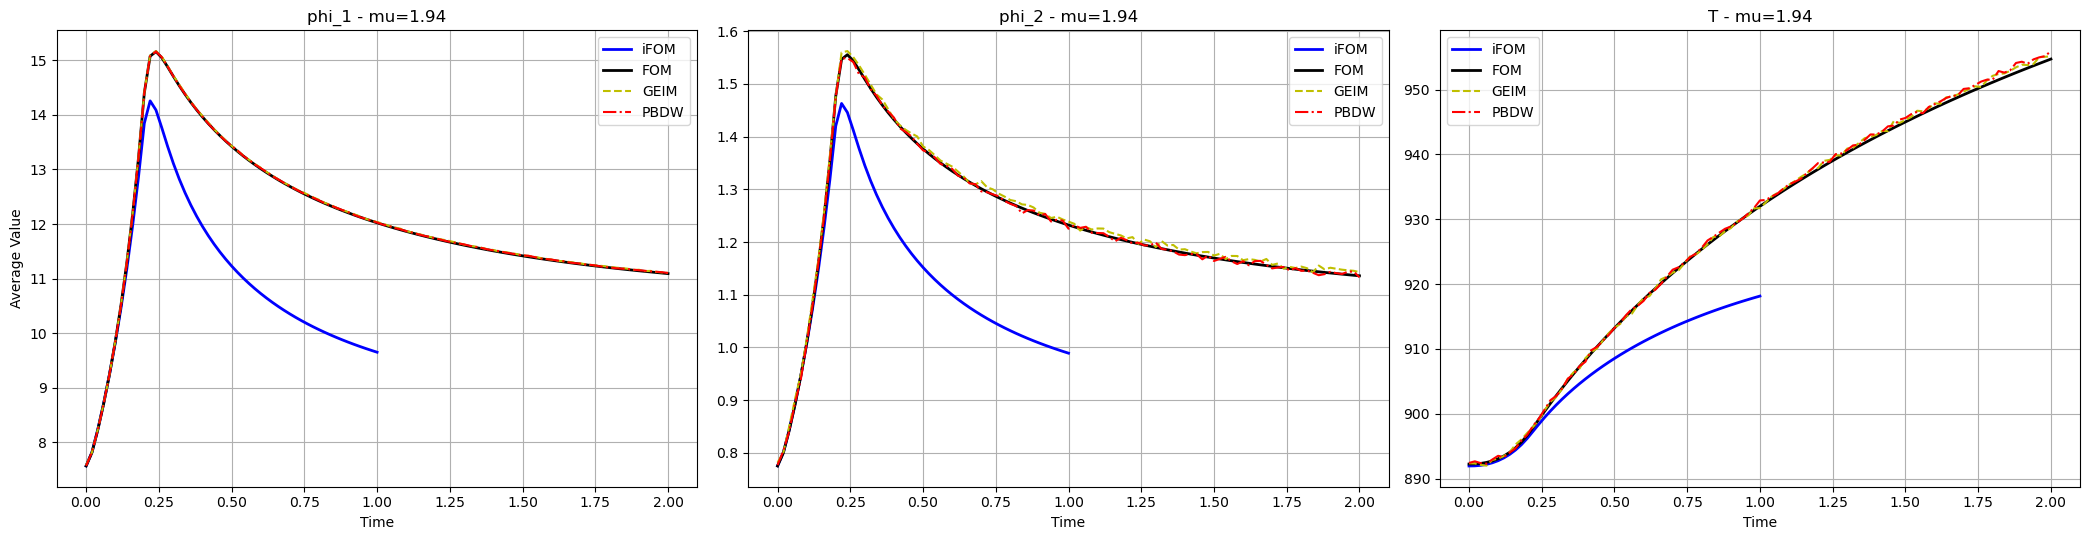

In [97]:
mu_to_plot = np.random.choice(np.arange(len(test_idx)))

fig, axs = plt.subplots(1, len(var_names), figsize=(7 * len(var_names), 5.5), sharex=True)

for field_i, field in enumerate(var_names):

    # Get iFOM snapshots for the selected mu
    _ifom = list()
    for tt in range(len(ifom_times)):
        _ifom.append(test_ifom_snaps[field](mu_to_plot * len(ifom_times) + tt))
    _ifom = np.asarray(_ifom).T

    axs[field_i].plot(ifom_times, _ifom.mean(axis=0), label='iFOM', color='b', linewidth=2)

    # Get FOM snapshots for the selected mu
    _fom = list()
    for tt in range(len(fom_times)):
        _fom.append(test_fom_snaps[field](mu_to_plot * len(fom_times) + tt))
    _fom = np.asarray(_fom).T

    axs[field_i].plot(fom_times, _fom.mean(axis=0), label='FOM', color='k', linewidth=2)

    # Get GEIM reconstruction for the selected mu
    _geim = recons['GEIM'][field][:, mu_to_plot * len(fom_times):(mu_to_plot + 1) * len(fom_times)]
    axs[field_i].plot(fom_times, _geim.mean(axis=0), label='GEIM', color='y', linestyle='--')

    # Get PBDW reconstruction for the selected mu
    _pbdw = recons['PBDW'][field][:, mu_to_plot * len(fom_times):(mu_to_plot + 1) * len(fom_times)]
    axs[field_i].plot(fom_times, _pbdw.mean(axis=0), label='PBDW', color='red', linestyle='-.')

    axs[field_i].set_title(f"{field} - mu={test_params[mu_to_plot]:.2f}")
    axs[field_i].set_xlabel("Time")
    axs[field_i].legend()
    axs[field_i].grid()

axs[0].set_ylabel("Average Value")

plt.tight_layout()

Let us make some contour plots of the different fields for the reconstructed state vs the FOM

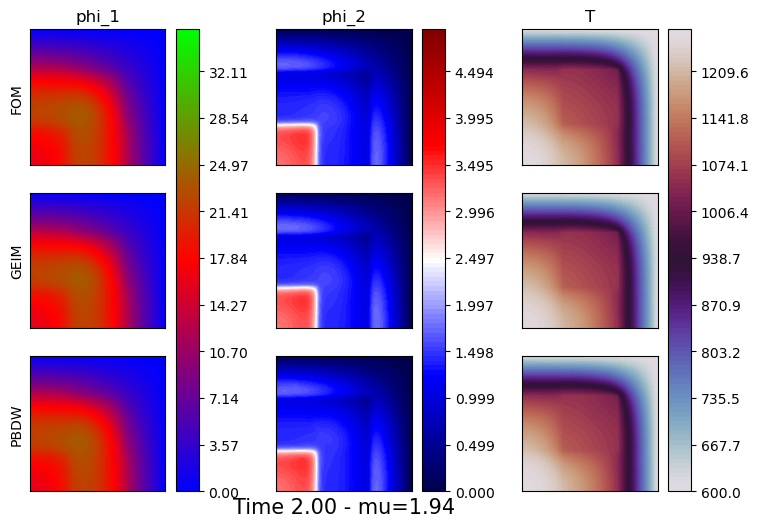

In [119]:
from utils import plot_contour
from matplotlib import cm

cmaps = [cm.brg, cm.seismic, cm.twilight]
levels = [
    np.linspace(test_fom_snaps[field].return_matrix().min(),
                test_fom_snaps[field].return_matrix().max(), 
                100)
    for field in var_names
]

sampling = 5
for tt in range(sampling, len(fom_times), sampling):

    fig, axs = plt.subplots(3, len(var_names), figsize=(3 * len(var_names), 2*3))

    for field_i, field in enumerate(var_names):

        cont = plot_contour(axs[0, field_i], domain.geometry.x, 
                    test_fom_snaps[field](mu_to_plot * len(fom_times) + tt),
                    cmap=cmaps[field_i], levels=levels[field_i])
        
        axs[0, field_i].set_title(f"{field}")
        
        plot_contour(axs[1, field_i], domain.geometry.x,
                    recons['GEIM'][field][:, mu_to_plot * len(fom_times) + tt],
                    cmap=cmaps[field_i], levels=levels[field_i])

        plot_contour(axs[2, field_i], domain.geometry.x,
                    recons['PBDW'][field][:, mu_to_plot * len(fom_times) + tt],
                    cmap=cmaps[field_i], levels=levels[field_i])

        fig.colorbar(cont, ax=axs[:, field_i], orientation='vertical')

    axs[0,0].set_ylabel("FOM")
    axs[1, 0].set_ylabel("GEIM")
    axs[2, 0].set_ylabel("PBDW")

    axs[-1,1].set_xlabel(f"Time {fom_times[tt]:.2f} - mu={test_params[mu_to_plot]:.2f}", fontsize=15)

    plt.show()
    clc(wait=True)
    plt.close(fig)